In [438]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import yfinance as yf
import pandas_datareader as pdr

from sklearn.metrics import accuracy_score

import logging

import sys
import os

from scipy.stats import binom_test
from mpl_toolkits.mplot3d import Axes3D
import math


In [439]:
class SuppressOutput:
    def __enter__(self):
        self.stdout = sys.stdout
        self.stderr = sys.stderr
        self.devnull = open(os.devnull, 'w')
        sys.stdout = self.devnull
        sys.stderr = self.devnull

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stderr.close()
        sys.stdout = self.stdout
        sys.stderr = self.stderr


In [440]:
def filter_data(ticker_list, start, end):

    data_list = []

    for ticker in ticker_list:
        with SuppressOutput():
            data = yf.download(ticker, start=start, end=end)
        data_list.append(data)

    return dict(zip(ticker_list, data_list))
        

    

In [441]:
def create_data(ticker, ticker_name, l_wind, s_wind, wind):

    df = pd.DataFrame(ticker)
    date = df.index.tolist()
    df['Date'] = pd.to_datetime(date)

    df['Index'] = list(range(0, len(df['Date'])))

    large_window = l_wind  # Moving average window size
    small_window = s_wind
    window = wind

    # Calculate the moving average
    df['LMA'] = df['Open'].ewm(span=large_window, adjust=False).mean()
    df['SMA'] = df['Open'].ewm(span=small_window, adjust=False).mean()
    df['MA'] = df['Open'].ewm(span=window, adjust=False).mean()

    # df['LMA'] = df['Open'].rolling(window=large_window).mean()
    # df['SMA'] = df['Open'].rolling(window=small_window).mean()
    # df['MA'] = df['Open'].rolling(window=window).mean()

    # print(df)


    # Create a plot
    # plt.figure(figsize=(20, 8))
    # plt.plot(df['Date'], df['Open'], label='Original Data')
    # plt.plot(df['Date'], df['LMA'], label=f'Long Moving Average ({large_window} days)')
    # plt.plot(df['Date'], df['SMA'], label=f'Short Moving Average ({small_window} days)')
    # plt.plot(df['Date'], df['MA'], label = f'Moving Average ({window} days)')
    # plt.xlabel('Date')
    # plt.ylabel('Value')
    # plt.title('Moving Average Plot')
    # plt.legend()
    # plt.grid(True)
    # path = "Experimental_Figures/" + ticker_name + ".png"
    # plt.savefig(path)
    # plt.close()

    return df








In [442]:
def create_train_set(ticker_list, start_date, end_date, large_window, short_window, window):
    ticker_dict = filter_data(ticker_list, start_date, end_date)

    for ticker in ticker_dict.keys():
        data = ticker_dict.get(ticker)
        ticker_dict[ticker] = create_data(data, ticker, large_window, short_window, window)

    return ticker_dict


def train_model(ticker_dict, large_window, short_window, window):

    train_set = []

    for ticker in ticker_dict.keys():
        train_set = train_set + get_crossover_data(ticker_dict[ticker], window)

    lma = [lma for _, lma, _ in train_set]
    sma = [sma for _, _, sma in train_set]
    gain = [gain for gain, _, _ in train_set]
    # # ma = [ma for _,_,_ in train_set]

    # print(gain.count(1) / len(gain))
    # print(len(gain))


    # Create a 3D scatter plot
    fig = plt.figure(figsize = (20, 8))
    # ax = fig.add_subplot(111, projection='3d')
    plt.scatter(lma, sma, c=gain, cmap='bwr', marker='o')

    # Add color bar
    cbar = plt.colorbar()
    cbar.set_label('Binary Value')

    plt.title("Scatter plot of winning (red) and losing (blue) trades based on rate of change in moving averages")
    plt.xlabel("Long-term Moving Average")
    plt.ylabel("Short-term Moving Average")

    # Set labels and title
    # ax.set_xlabel('X-axis')
    # ax.set_ylabel('Y-axis')
    # ax.set_zlabel('Z-axis')
    # ax.set_title('Scatter Plot with Binary Color')

    # Show the plot
    plt.show()

    target = [target for target, _, _ in train_set]
    features = [(x,y) for _,x,y in train_set]

    print("Valid crossovers:", len(target))
    print("Successful crossovers:", target.count(1))

    model = RandomForestClassifier(n_estimators = 20, max_depth = 4)
    # model = LogisticRegression()
    model.fit(features, target)

    # Make predictions on the test set
    y_pred = model.predict(features)

    preds = list(y_pred)

    print(preds.count(1))

    correct_signals = 0

    trades = 0

    for i in range(0, len(preds)):
        confidence = model.predict_proba(np.array(features[i]).reshape(1, -1))[0, 1]
        if preds[i] == 1 and confidence > .7:
            trades += 1
            if preds[i] == target[i]:
                correct_signals += 1

    print("Amount of trades", trades)
    print("Amount of successful trades", correct_signals)
    # Calculate accuracy
    accuracy = accuracy_score(target, y_pred)
    print("Accuracy:", accuracy)

    return model



In [575]:
def create_test_set(ticker_list, start_date, end_date, large_window, short_window, window):
    ticker_dict = filter_data(ticker_list, start_date, end_date)

    for ticker in ticker_dict.keys():
        data = ticker_dict.get(ticker)
        ticker_dict[ticker] = create_data(data, ticker, large_window, short_window, window)

    return ticker_dict

def test_model(ticker_dict, large_window, short_window, window, model):

    train_set = []

    for ticker in ticker_dict.keys():
        train_set = train_set + get_crossover_data(ticker_dict[ticker], window)

    target = [target for target, _, _ in train_set]
    features = [(x,y) for _,x,y in train_set]

    print("Valid crossovers:", len(target))
    print("Successful crossovers:", target.count(1))

    # Make predictions on the test set
    y_pred = model.predict(features)

    preds = list(y_pred)

    print("Predicted successful crossovers:", preds.count(1))

    correct_signals = 0

    trades = 0

    for i in range(0, len(preds)):
        confidence = model.predict_proba(np.array(features[i]).reshape(1, -1))[0, 1]
        if preds[i] == 1 and confidence > .75:
            trades += 1
            if preds[i] == target[i]:
                correct_signals += 1

    print("Amount of trades", trades)
    print("Amount of successful trades", correct_signals)
    # Calculate accuracy
    accuracy = accuracy_score(target, y_pred)
    print("Accuracy:", accuracy)

    return (correct_signals / trades, target.count(1) / len(target))



In [576]:
window = 200
large_window = 80
small_window = 20


In [515]:
start_date = '2020-09-01'
end_date = '2023-08-31'

recent_start = '2022-08-01'
recent_end = '2023-09-05'

long_start = '2013-08-31'
long_end = '2023-08-31'

train_start = '2010-08-31'
train_end = '2018-08-31'

init_start = '2001-08-31'
init_end = '2010-08-31'

sp_df = pd.read_csv('symbols.csv')

sp_list = list(sp_df['Symbol'])

common_list = commonly_traded_stocks = [
    "AAPL", "MSFT", "AMZN", "GOOGL", "META", "TSLA", "NVDA", "NFLX", "JPM", "V",
    "JNJ", "PG", "WMT", "KO", "MCD", "HD", "BA", "INTC", "CRM", "ADBE",
    "PFE", "T", "XOM", "CVX", "IBM", "GE", "VZ", "DIS", "MA", "BAC",
    "CMCSA", "TMO", "MRK", "UNH", "NKE", "WFC", "PYPL", "CSCO", "PEP",
    "PM", "BMY", "ABBV", "LLY", "CVS", "GILD", "QCOM", "DHR", "AMGN",
    "COST", "MCD", "TXN", "LIN", "NOW", "PFE", "LMT", "NEE", "TGT",
    "FDX", "HON", "ACN", "UNH", "LOW", "KHC", "DUK", "AAL", "NOC",
    "MET", "INTU", "UPS", "C", "SBUX", "ORCL", "NEE", "AMD", "DE",
    "ISRG", "CAT", "AMAT", "MO", "WBA", "MDT", "VRTX", "MS", "SYK",
    "MMM", "TMO", "PLD", "INTC", "ADI", "GS", "GM", "BDX", "VLO",
    "CL", "CI", "MDLZ", "SPGI", "CCI", "SO", "ANTM", "FISV", "AXP",
    "GILD", "SYF", "BDX", "SPG", "TROW", "CNC", "DELL", "ZTS", "SNPS"
]

common_ticks = [
    "TSLA", "NIO", "AMD", "WBD", "NU", "TLRY", "NVDA", "AAPL", "PLTR", "INTC",
    "AMZN", "BAC", "F", "VALE", "WBA", "PARA", "XPEV", "DELL", "DNA", "DIS",
    "NUVA", "KVUE", "RIVN", "BEKE", "MARA", "GRAB", "GOOGL", "BKI", "LCID", "T",
    "HPE", "RIG", "AFRM", "CMCSA", "SWN", "SNAP", "OPEN", "SOFI", "PFE", "BABA",
    "HZNP", "CCL", "GOOG", "LYFT", "S", "MSFT", "XOM", "AAL", "VZ", "UBER", "KMI",
    "CSCO", "GSAT", "SHOP", "USB", "PDD", "META", "WFC", "C", "BBD", "CSX", "NOK",
    "GOLD", "JD", "LU", "PYPL", "IQ", "KEY", "KO", "PLUG", "FCX", "MU", "DG", "CVNA",
    "PCG", "RYCEY", "SIRI", "TAL", "BCS", "CHWY", "MRO", "IOT", "NTNX", "HPQ", "KGC",
    "XP", "HBAN", "YMM", "SCHW", "DVN", "RBLX", "DKNG", "HOOD", "LYG", "OXY", "ET",
    "GM", "M", "HAL", "JNJ", "OLN", "BKR", "NEE", "CVE", "ABCM", "DISH", "TFC",
    "JPM", "AGNC", "IONQ", "KHC", "RF", "MRVL", "MDLZ", "FOXA", "STLA", "ROKU",
    "TSM", "CVX", "NKE", "CVS", "SBUX", "CRM", "GPS", "INFY", "QCOM", "LULU", "FITB"
]


# common_init1 = create_train_set(common_ticks, init_start, init_end, large_window, small_window, window)
common_mid1 = create_train_set(common_ticks, start_date, end_date, large_window, small_window, window)
common_short1 = create_train_set(common_ticks, recent_start, recent_end, large_window, small_window, window)
common_long1 = create_train_set(common_ticks, train_start, train_end, large_window, small_window, window)

# common_init2 = create_train_set(common_list, init_start, init_end, large_window, small_window, window)
# common_mid2 = create_train_set(common_list, start_date, end_date, large_window, small_window, window)
# common_short2 = create_train_set(common_list, recent_start, recent_end, large_window, small_window, window)
# common_long2 = create_train_set(common_list, train_start, train_end, large_window, small_window, window)

In [694]:


def get_crossover_data(dataset, window):
    train_data = []
    for i in range(20, len(dataset) - 25):
        if dataset['SMA'][i - 6] <= dataset['LMA'][i - 6] and dataset['SMA'][i - 5] > dataset['LMA'][i - 5]:
            lma_change = (dataset['LMA'][i] - dataset['LMA'][i - 10]) / dataset['LMA'][i - 10] / 10
            sma_change = (dataset['SMA'][i] - dataset['SMA'][i - 10]) / dataset['SMA'][i - 10] / 10
            ma_change = (dataset['MA'][i] - dataset['MA'][i - 20]) / dataset['MA'][i - 20]
            if(lma_change > .002):
                future = list(dataset['High'][i+2:i+20])
                gain = 1 if any(value > dataset['Open'][i + 1] * 1.05 for value in future) else 0
                train_data.append((gain, lma_change, sma_change))
    return train_data

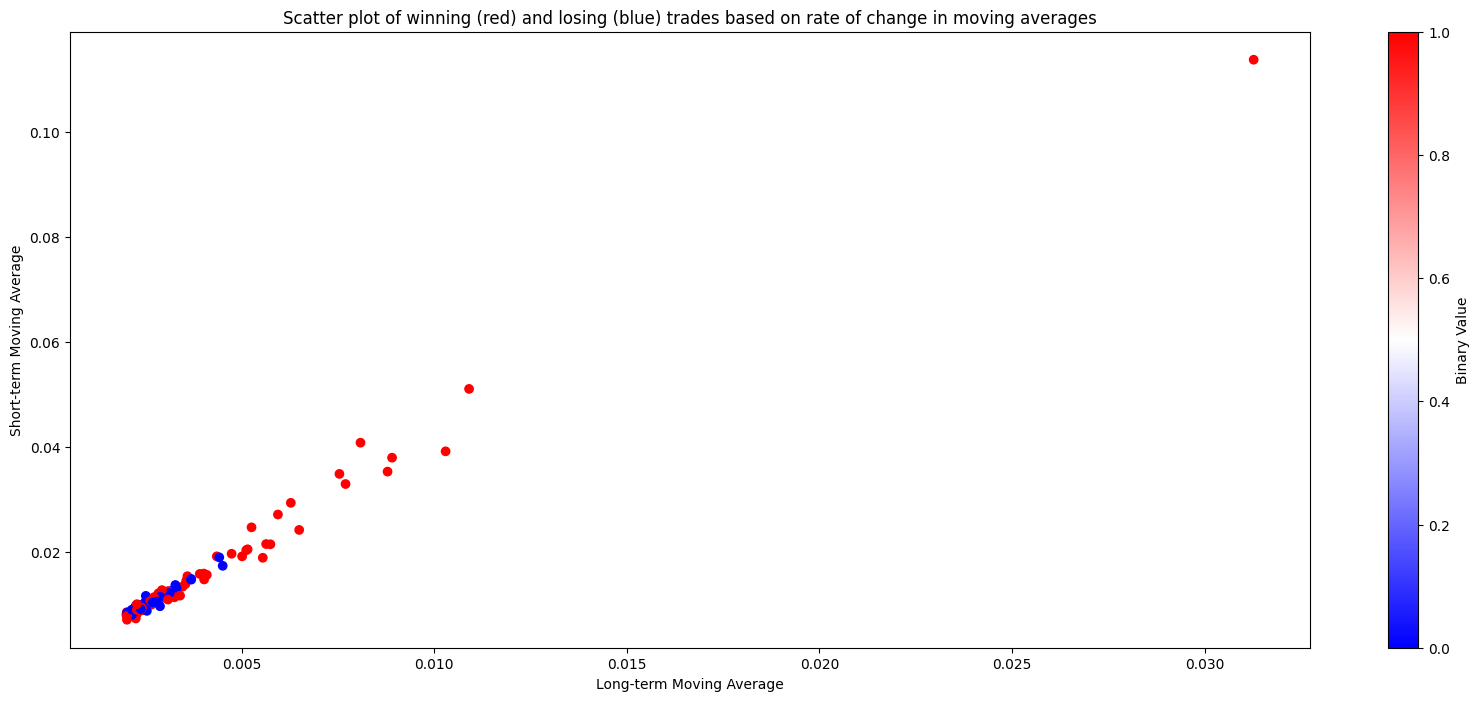

Valid crossovers: 123
Successful crossovers: 78
86
Amount of trades 46
Amount of successful trades 46
Accuracy: 0.8048780487804879


In [695]:

model = train_model(common_long1, large_window, small_window, window)

In [696]:
test_model(common_mid1, large_window, small_window, window, model)

Valid crossovers: 170
Successful crossovers: 129
Predicted successful crossovers: 128
Amount of trades 53
Amount of successful trades 41
Accuracy: 0.6647058823529411


(0.7735849056603774, 0.7588235294117647)

TSLA
64
Date: 2020-12-02 00:00:00, Buy: 196.673, Sell Date: 2020-12-08 00:00:00, Sell: 208.503, Move: 0.060, Held for 2
TSLA
401
Date: 2022-04-05 00:00:00, Buy: 357.823, Sell Date: 2022-05-04 00:00:00, Sell: 317.540, Move: -0.113, Held for 19
NIO
462
Date: 2022-07-05 00:00:00, Buy: 21.810, Sell Date: 2022-07-08 00:00:00, Sell: 22.160, Move: 0.016, Held for 1
WBD
606
Date: 2023-01-30 00:00:00, Buy: 14.450, Sell Date: 2023-02-02 00:00:00, Sell: 15.520, Move: 0.074, Held for 1
TLRY
50
Date: 2020-11-11 00:00:00, Buy: 7.700, Sell Date: 2020-11-25 00:00:00, Sell: 7.660, Move: -0.005, Held for 8
PLTR
660
Date: 2023-05-16 00:00:00, Buy: 9.540, Sell Date: 2023-05-19 00:00:00, Sell: 11.970, Move: 0.255, Held for 1
INTC
652
Date: 2023-04-05 00:00:00, Buy: 32.600, Sell Date: 2023-05-04 00:00:00, Sell: 31.240, Move: -0.042, Held for 19
PARA
394
Date: 2022-03-25 00:00:00, Buy: 38.420, Sell Date: 2022-04-25 00:00:00, Sell: 31.200, Move: -0.188, Held for 19
XPEV
49
Date: 2020-11-10 00:00:00, Buy: 31.2

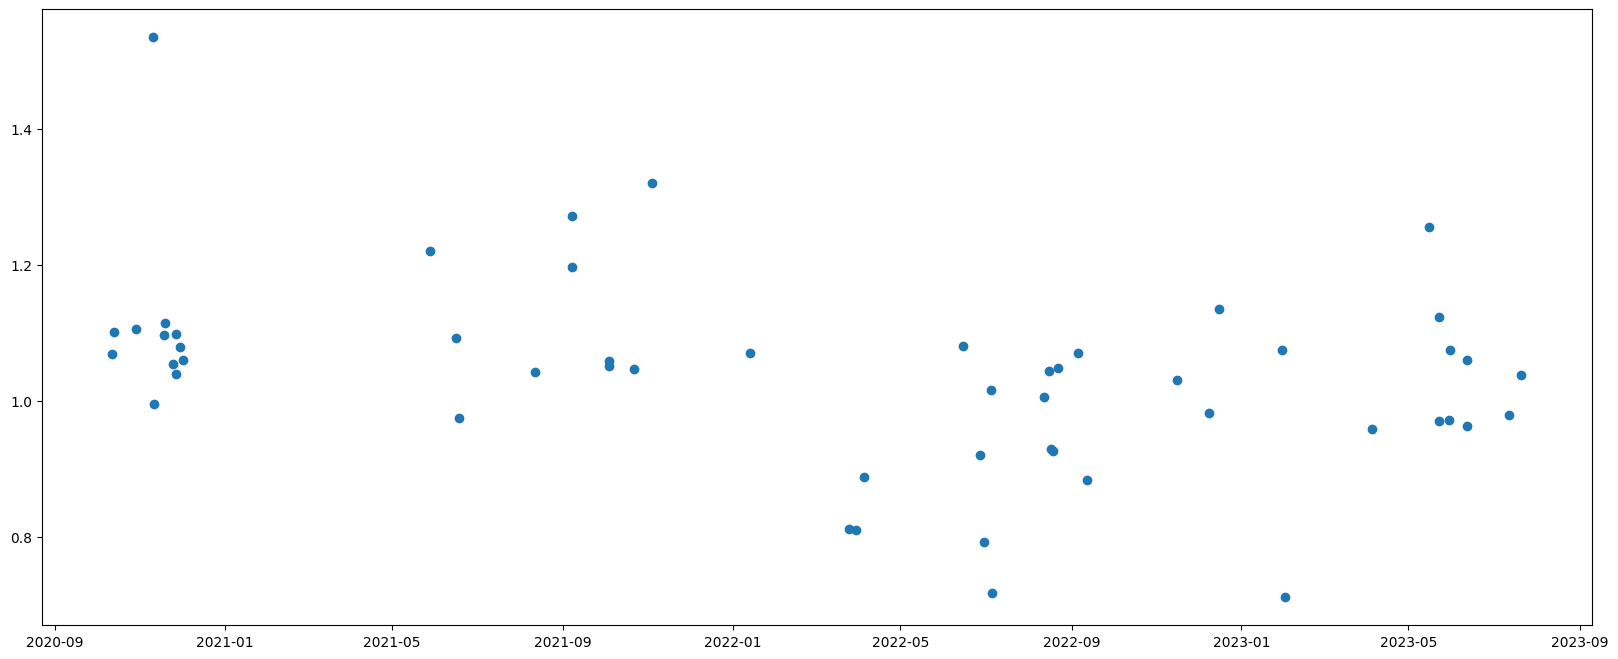

In [697]:


def get_simulation_data(ticker_dict, window, model):
    trade_data = []
    for ticker in ticker_dict.keys():
        dataset = ticker_dict[ticker]
        for i in range(20, len(dataset) - 25):
            if dataset['SMA'][i - 6] <= dataset['LMA'][i - 6] and dataset['SMA'][i - 5] > dataset['LMA'][i - 5]:
                lma_change = (dataset['LMA'][i] - dataset['LMA'][i - 10]) / dataset['LMA'][i - 10] / 10
                sma_change = (dataset['SMA'][i] - dataset['SMA'][i - 10]) / dataset['SMA'][i - 10] / 10
                ma_change = (dataset['MA'][i] - dataset['MA'][i - 20]) / dataset['MA'][i - 20]

                if(lma_change > .002 and model.predict_proba(np.array([lma_change, sma_change]).reshape(1, -1))[0, 1] > .75):
                    date = dataset['Date'][i]
                    buy = dataset['Open'][i + 1]
                    sell = 0
                    buy_activated = False
                    # sell = dataset['Open'][i + 1] * 1.1 if any(value > dataset['Open'][i + 1] * 1.1 for value in future) else dataset['Close'][i + 80]
                    for n in range(i+2, i + 20):
                        if buy_activated == False and dataset['High'][n] > dataset['Open'][i + 1] * 1.05:
                            sell = dataset['Open'][n + 1]
                            sell_date = dataset['Date'][n + 1]
                            hold_period = n - (i + 1)
                            break

                    if sell == 0:
                        sell = dataset['Close'][i + 20]
                        sell_date = dataset['Date'][i + 20]
                        hold_period = i + 20 - (i + 1)
                    trade_data.append((date, buy, sell, sell_date, hold_period, ticker, i))
    return trade_data

def get_upward_data(ticker_dict, window):
    trade_data = []
    for ticker in ticker_dict.keys():
        dataset = ticker_dict[ticker]
        for i in range(window + 30, len(dataset) - 80):
            if dataset['SMA'][i - 31] <= dataset['LMA'][i - 31] and dataset['SMA'][i - 30] > dataset['LMA'][i - 30]:
                lma_change = (dataset['LMA'][i] - dataset['LMA'][i - 60]) / dataset['LMA'][i - 60] / 60
                sma_change = (dataset['SMA'][i] - dataset['SMA'][i - 60]) / dataset['SMA'][i - 60] / 60
                ma_change = (dataset['MA'][i] - dataset['MA'][i - 20]) / dataset['MA'][i - 20]
                angle_rad = math.atan(abs(sma_change - ma_change) / (1 + sma_change * ma_change))
                predictor = dataset['LMA'][i - 30] / dataset['SMA'][i - 30]
                if(lma_change > .0015):
                    date = dataset['Date'][i]
                    buy = dataset['Open'][i + 1]
                    future = list(dataset['High'][i+2:i+40])
                    sell = 0
                    # sell = dataset['Open'][i + 1] * 1.1 if any(value > dataset['Open'][i + 1] * 1.1 for value in future) else dataset['Close'][i + 80]
                    for n in range(i+2, i + 40):
                        if dataset['High'][n] > dataset['Open'][i + 1] * 1.05:
                            sell = dataset['Open'][n + 1]
                            sell_date = dataset['Date'][n + 1]
                            hold_period = n - (i + 1)
                            break
                        if dataset['Low'][n] < dataset['Open'][i+1] * .7:
                            sell = dataset['Open'][i+1] * .7
                            sell_date = dataset['Date'][n + 1]
                            hold_period = n - (i + 1)
                            break
                    if sell == 0:
                        sell = dataset['Close'][i + 40]
                        sell_date = dataset['Date'][i + 40]
                        hold_period = i + 40 - (i + 1)
                    trade_data.append((date, buy, sell, sell_date, hold_period, ticker))
    return trade_data

def get_downward_data(ticker_dict, window):
    trade_data = []
    for ticker in ticker_dict.keys():
        dataset = ticker_dict[ticker]
        for i in range(window + 30, len(dataset) - 80):
            if dataset['SMA'][i - 31] <= dataset['LMA'][i - 31] and dataset['SMA'][i - 30] > dataset['LMA'][i - 30]:
                lma_change = (dataset['LMA'][i] - dataset['LMA'][i - 60]) / dataset['LMA'][i - 60] / 60
                sma_change = (dataset['SMA'][i] - dataset['SMA'][i - 60]) / dataset['SMA'][i - 60] / 60
                ma_change = (dataset['MA'][i] - dataset['MA'][i - 20]) / dataset['MA'][i - 20]
                angle_rad = math.atan(abs(sma_change - ma_change) / (1 + sma_change * ma_change))
                predictor = dataset['LMA'][i - 30] / dataset['SMA'][i - 30]
                if(lma_change < -.001):
                    date = dataset['Date'][i]
                    buy = dataset['Open'][i + 1]
                    future = list(dataset['High'][i+2:i+40])
                    sell = 0
                    # sell = dataset['Open'][i + 1] * 1.1 if any(value > dataset['Open'][i + 1] * 1.1 for value in future) else dataset['Close'][i + 80]
                    for n in range(i+2, i + 40):
                        if dataset['High'][n] > dataset['Open'][i + 1] * 1.05:
                            sell = dataset['Open'][n + 1]
                            sell_date = dataset['Date'][n + 1]
                            hold_period = n - (i + 1)
                            break
                        if dataset['Low'][n] < dataset['Open'][i+1] * .8:
                            sell = dataset['Open'][i+1] * .9
                            sell_date = dataset['Date'][n + 1]
                            hold_period = n - (i + 1)
                            break
                    if sell == 0:
                        sell = dataset['Close'][i + 40]
                        sell_date = dataset['Date'][i + 40]
                        hold_period = i + 40 - (i + 1)
                    trade_data.append((date, buy, sell, sell_date, hold_period, ticker))
    return trade_data

def simulate_model(ticker_dict, window, model):
    trade_data = []
    trade_data = get_simulation_data(ticker_dict, window, model)
    # up_data = get_upward_data(ticker_dict, window)
    # down_data = get_downward_data(ticker_dict, window)

    # trade_data += up_data
    # trade_data += down_data

    trade_df = pd.DataFrame(trade_data, columns=['Date', 'Buy', 'Sell', 'Sell_date', 'Hold', 'Ticker', 'i'])

    trade_df['Date'] = pd.to_datetime(trade_df['Date'])
    count = 0
    total = 0
    profit = 0
    move = []
    for index, row in trade_df.iterrows():
        if row["Buy"] < row["Sell"]:
            count += 1
        percent = row["Sell"] / row["Buy"] - 1
        move.append(percent)

        total += 1
        profit += 1000 * row["Sell"] / row["Buy"] - 1000
        print(row['Ticker'])
        print(row['i'])
        print("Date: {}, Buy: {:.3f}, Sell Date: {}, Sell: {:.3f}, Move: {:.3f}, Held for {}".format(row["Date"], row["Buy"], row['Sell_date'], row["Sell"], percent, row['Hold']))


    loss = [m for m in move if m < 0]
    win = [w for w in move if w > 0]
    print(count)
    print(total)
    print(np.mean(win))
    print(np.mean(loss))
    print(np.mean(trade_df['Hold']))

    percent = trade_df["Sell"] / trade_df["Buy"] 

    plt.figure(figsize = (20, 8))
    plt.scatter(trade_df['Date'], percent)

simulate_model(common_mid1, window, model)

    





    

In [698]:
def simulate_trades(ticker_dict, window, initial_capital, trade_amount, model):
    capital = initial_capital
    trade_data = get_simulation_data(ticker_dict, window, model)
    # up_data = get_upward_data(ticker_dict, window)
    # down_data = get_downward_data(ticker_dict, window)

    # trade_data += up_data
    # trade_data += down_data

    trade_df = pd.DataFrame(trade_data, columns=['Date', 'Buy', 'Sell', 'Sell_date', 'Hold', 'Ticker', 'i'])
    sorted_df = trade_df.sort_values(by='Date')
    sorted_df = sorted_df.reset_index(drop=True)

    date_range = pd.date_range(start= "2000-05-03", end= "2023-09-03")
    date_list = date_range.tolist()

    positions = []

    wins = []
    loss = []



    for i in date_list:
        for pos in positions:
            if pos[2] == i:
                print("Sell {} on {}: {:.3f}".format(pos[4], pos[2], pos[1]))
                if pos[1] / pos[0] * trade_amount > trade_amount:
                    wins.append(pos[1] / pos[0] - 1)
                    capital += trade_amount + (pos[1] / pos[0] * trade_amount - trade_amount) * .95
                else:
                    loss.append(pos[1] / pos[0] - 1)

                    capital += pos[1] / pos[0] * trade_amount
                positions.remove(pos)

        for n in range(len(sorted_df['Date'])):
            if sorted_df['Date'][n] == i and capital > trade_amount:
                capital -= trade_amount
                print("Buy {} on {}: {:.3f}".format(sorted_df['Ticker'][n], sorted_df['Date'][n], sorted_df['Buy'][n]))
                positions.append([sorted_df['Buy'][n], sorted_df['Sell'][n], sorted_df['Sell_date'][n], sorted_df['Hold'][n], sorted_df['Ticker'][n]])

    print((capital + len(positions) * trade_amount) / initial_capital)
    print(len(wins))
    print(len(loss))
    print(wins)
    print(loss)
    print(np.mean(wins))
    print(np.mean(loss))

    print()

    

simulate_trades(common_mid1, window, 7000, 1500, model)

Buy PLUG on 2020-10-12 00:00:00: 17.300
Buy GPS on 2020-10-13 00:00:00: 19.480
Sell GPS on 2020-10-23 00:00:00: 21.450
Buy MARA on 2020-10-29 00:00:00: 2.270
Sell MARA on 2020-11-05 00:00:00: 2.510
Sell PLUG on 2020-11-06 00:00:00: 18.500
Buy XPEV on 2020-11-10 00:00:00: 31.260
Buy TLRY on 2020-11-11 00:00:00: 7.700
Sell XPEV on 2020-11-13 00:00:00: 47.960
Buy LYFT on 2020-11-18 00:00:00: 39.600
Buy DVN on 2020-11-19 00:00:00: 13.500
Sell DVN on 2020-11-24 00:00:00: 15.040
Sell TLRY on 2020-11-25 00:00:00: 7.660
Buy MRO on 2020-11-25 00:00:00: 6.460
Buy OXY on 2020-11-27 00:00:00: 16.240
Buy RIG on 2020-11-27 00:00:00: 2.020
Buy HAL on 2020-11-30 00:00:00: 17.240
Sell LYFT on 2020-12-03 00:00:00: 43.410
Sell RIG on 2020-12-03 00:00:00: 2.100
Sell HAL on 2020-12-04 00:00:00: 18.610
Sell MRO on 2020-12-07 00:00:00: 6.810
Buy GSAT on 2021-05-28 00:00:00: 1.630
Buy LCID on 2021-06-16 00:00:00: 23.440
Buy XPEV on 2021-06-18 00:00:00: 44.930
Sell GSAT on 2021-06-23 00:00:00: 1.990
Sell LCID 

In [701]:
def get_signal_data(ticker_dict, window, model):
    trade_data = []
    for ticker in ticker_dict.keys():
        dataset = ticker_dict[ticker]
        for i in range(20, len(dataset)):
            if dataset['SMA'][i - 6] <= dataset['LMA'][i - 6] and dataset['SMA'][i - 5] > dataset['LMA'][i - 5]:
                lma_change = (dataset['LMA'][i] - dataset['LMA'][i - 10]) / dataset['LMA'][i - 10] / 10
                sma_change = (dataset['SMA'][i] - dataset['SMA'][i - 10]) / dataset['SMA'][i - 10] / 10
                ma_change = (dataset['MA'][i] - dataset['MA'][i - 20]) / dataset['MA'][i - 20]

                if(lma_change > .0015 and model.predict_proba(np.array([lma_change, sma_change]).reshape(1, -1))[0, 1] > .75):
                    date = dataset['Date'][i]
                    sell = 0
                    # sell = dataset['Open'][i + 1] * 1.1 if any(value > dataset['Open'][i + 1] * 1.1 for value in future) else dataset['Close'][i + 80]
                    trade_data.append((date, ticker))
    return trade_data

def create_trade_signals(ticker_dict, window, initial_capital, trade_amount, model):
    capital = initial_capital
    trade_data = get_signal_data(ticker_dict, window, model)
    # up_data = get_upward_data(ticker_dict, window)
    # down_data = get_downward_data(ticker_dict, window)

    # trade_data += up_data
    # trade_data += down_data

    trade_df = pd.DataFrame(trade_data, columns=['Date', 'Ticker'])
    sorted_df = trade_df.sort_values(by='Date')
    sorted_df = sorted_df.reset_index(drop=True)

    date_range = pd.date_range(start= "2020-10-11", end= "2023-09-05")
    date_list = date_range.tolist()

    # positions = []

    wins = []
    loss = []


    to_buy = []
    positions = []
    to_sell = []

    loss = []
    wins = []

    dates = []
    portfolio = []

    for i in date_list:
        # Buy positions the next day

        for asset in to_buy:
            asset_df = ticker_dict[asset[0]]
            index = list(asset_df['Date']).index(asset[1])
            if(i == (asset_df['Date'][index + 1])):
                print("{} bought on {}: {:.3f}".format(asset[0], i, asset_df['Open'][index + 1]))
                capital -= trade_amount
                positions.append([asset[0], asset_df['Open'][index + 1], 20])
                to_buy.remove(asset)




        # Sell positions

        for asset in to_sell:
            asset_df = ticker_dict[asset[0][0]]
            if i == asset_df['Date'][asset[1]]:
                sell_price = asset_df['Open'][asset[1]]
                buy_price = asset[0][1]
                capital += trade_amount * (sell_price / buy_price)
                print("{} sold on {}: {:.3f}, move: {:.3f}".format(asset[0][0], i, sell_price, sell_price / buy_price - 1))
                to_sell.remove(asset)
                positions.remove(asset[0])
                move = sell_price / buy_price - 1
                if move < 0:
                    loss.append(move)
                if move > 0:
                    wins.append(move)
                


        # Mark position for selling

        for asset in positions:
            asset_df = ticker_dict[asset[0]]
            if i in asset_df['Date']:
                index = list(asset_df['Date']).index(i)
                asset[2]-= 1
                if asset_df['High'][index] > asset[1] * 1.05:
                    to_sell.append([asset, index + 1])
                    print("Sell signal: {} on {}".format(asset[0], i))
                elif asset[2] == 0:
                    to_sell.append([asset, index + 1])
                    print("Limit reached")
                






        # Create buy signal
        for n in range(len(sorted_df['Date'])):
            if sorted_df['Date'][n] == i and capital > trade_amount:
                # capital -= trade_amount
                print("Buy signal: {} on {}".format(sorted_df['Ticker'][n], sorted_df['Date'][n]))
                to_buy.append((sorted_df['Ticker'][n], sorted_df['Date'][n]))

                # positions.append([sorted_df['Buy'][n], sorted_df['Sell'][n], sorted_df['Sell_date'][n], sorted_df['Hold'][n], sorted_df['Ticker'][n]])

        portfolio.append((capital + len(positions) * trade_amount))
        dates.append(i)

    # print((capital + len(positions) * trade_amount) / initial_capital)
    # print(len(wins))
    # print(len(loss))
    # print(np.mean(wins))
    # print(np.mean(loss))
    # plt.plot(dates, portfolio)

    return (capital + len(positions) * trade_amount) / initial_capital

create_trade_signals(common_mid1, window, 7000, 1500, model)

Buy signal: CVNA on 2020-10-12 00:00:00
Buy signal: PLUG on 2020-10-12 00:00:00
CVNA bought on 2020-10-13 00:00:00: 210.520
Sell signal: CVNA on 2020-10-13 00:00:00
Buy signal: GPS on 2020-10-13 00:00:00
GPS bought on 2020-10-14 00:00:00: 19.480
CVNA sold on 2020-10-14 00:00:00: 219.135, move: 0.041
Buy signal: TFC on 2020-10-14 00:00:00
TFC bought on 2020-10-15 00:00:00: 42.970
Sell signal: GPS on 2020-10-22 00:00:00
GPS sold on 2020-10-23 00:00:00: 21.450, move: 0.101
Buy signal: MARA on 2020-10-29 00:00:00
MARA bought on 2020-10-30 00:00:00: 2.270
Sell signal: TFC on 2020-11-03 00:00:00
TFC sold on 2020-11-04 00:00:00: 43.260, move: 0.007
Sell signal: MARA on 2020-11-04 00:00:00
MARA sold on 2020-11-05 00:00:00: 2.510, move: 0.106
Buy signal: GOOGL on 2020-11-10 00:00:00
Buy signal: XPEV on 2020-11-10 00:00:00
Buy signal: GOOG on 2020-11-10 00:00:00
Buy signal: BCS on 2020-11-10 00:00:00
GOOGL bought on 2020-11-11 00:00:00: 87.420
GOOG bought on 2020-11-11 00:00:00: 87.500
Buy signa

1.280689996364502